In [1]:
import datetime
from dateutil.parser import parse
import itertools
from itertools import product
import math
import matplotlib.pyplot as plt
from multiprocessing.dummy import Pool as ThreadPool
import nolds
import numpy as np
import os
import pandas as pd
import pathlib
from PreprocessFcns import *
import pywt
import random
import scipy
from scipy.fftpack import fft
from scipy.signal import butter, welch, filtfilt, resample
from scipy.stats import skew, kurtosis, entropy, pearsonr
import seaborn as sns
import sklearn
from sklearn import multiclass
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneGroupOut
import time
%matplotlib inline

In [5]:
# set path to folder containing clinic watch data
path = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
# set path to destination folder
dest = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'
#---------------------------------------------------------------------------------------------------------

In [3]:
VisitNumber = {
    '2 Weeks: Time 0'   : 0,
    '2 Weeks: Time 30'  : 1,
    '2 Weeks: Time 60'  : 2,
    '2 Weeks: Time 90'  : 3,
    '2 Weeks: Time 120' : 4,
    '2 Weeks: Time 150' : 5,
    '1 Month'           : 6
}

ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

In [182]:
s_time = time.time()

ClipData = pd.read_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeaturesX.csv'))[['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                                                                                      'Tremor', 'Bradykinesia', 'Dyskinesia', 
                                                                                      'Overall']]

ClinicFreqData = pd.DataFrame()
ClipFreqData = pd.DataFrame()
for clip in ClipData.iterrows():
    clipacc = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', 
                                       str(int(clip[1]['SubjID'])) + '_' + str(clip[1]['Visit']) + '_' + 
                                       clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip']) + '.csv'), 
                          parse_dates = ['Timestamp'])
    
    clipacc_mag = np.sqrt((clipacc.X)**2 + (clipacc.Y)**2 + (clipacc.Z)**2)
    L = len(clipacc_mag)
    Fs = L / (((pd.to_datetime(clipacc.Timestamp).values.astype(np.int64) // 10**6)[-1] - 
                              (pd.to_datetime(clipacc.Timestamp).values.astype(np.int64) // 10**6)[0]) / 1000)
    P1 = np.abs((fft(clipacc_mag))/L)[:int(L/2 + 1)]
    f = Fs * range(int(L / 2) + 1) / L
    clipFFT = pd.DataFrame()
    clipFFT['f'] = f
    clipFFT['P1'] = P1
    
    ClipFreqData['SubjID'] = [int(clip[1]['SubjID'])]
    ClipFreqData['Visit'] = [clip[1]['Visit']]
    ClipFreqData['TaskAbb'] = [clip[1]['TaskAbb']]
    ClipFreqData['Clip'] = [clip[1]['Clip']]
    ClipFreqData['Tremor'] = [clip[1]['Tremor']]
    ClipFreqData['Bradykinesia'] = [clip[1]['Bradykinesia']]
    ClipFreqData['Dyskinesia'] = [clip[1]['Dyskinesia']]
    ClipFreqData['Overall'] = [clip[1]['Overall']]
    ClipFreqData['0-2'] = [np.mean(clipFFT.P1[(clipFFT.f >= 0) & (clipFFT.f <= 2)])]
    ClipFreqData['2-4'] = [np.mean(clipFFT.P1[(clipFFT.f >= 2) & (clipFFT.f <= 4)])]
    ClipFreqData['4-6'] = [np.mean(clipFFT.P1[(clipFFT.f >= 4) & (clipFFT.f <= 6)])]
    
    ClipFreqData['4-8'] = [np.mean(clipFFT.P1[(clipFFT.f >= 4) & (clipFFT.f <= 8)])]
    
    ClipFreqData['6-8'] = [np.mean(clipFFT.P1[(clipFFT.f >= 6) & (clipFFT.f <= 8)])]
    ClipFreqData['8-10'] = [np.mean(clipFFT.P1[(clipFFT.f >= 8) & (clipFFT.f <= 10)])]
    ClipFreqData['10-12'] = [np.mean(clipFFT.P1[(clipFFT.f >= 10) & (clipFFT.f <= 12)])]
    ClipFreqData['12-14'] = [np.mean(clipFFT.P1[(clipFFT.f >= 12) & (clipFFT.f <= 14)])]
    ClipFreqData['14-16'] = [np.mean(clipFFT.P1[(clipFFT.f >= 14) & (clipFFT.f <= 16)])]
    ClipFreqData['16-18'] = [np.mean(clipFFT.P1[(clipFFT.f >= 16) & (clipFFT.f <= 18)])]
    ClipFreqData['18-20'] = [np.mean(clipFFT.P1[(clipFFT.f >= 18) & (clipFFT.f <= 20)])]
    
    if ClinicFreqData.empty:
        ClinicFreqData = ClipFreqData
        continue
    ClinicFreqData = pd.concat([ClinicFreqData, ClipFreqData], ignore_index = True)

print(str(int(((time.time() - s_time) / 60) / 60)) + ' hours ' + 
      str(int(((time.time() - s_time) / 60) % 60)) + ' minutes ' + 
      str(int((time.time() - s_time) % 60)) + ' seconds')
    
ClinicFreqData

0 hours 8 minutes 9 seconds


,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,0-2,2-4,4-6,4-8,6-8,8-10,10-12,12-14,14-16,16-18,18-20
0,1003,0,Drnkg,1,1.0,1.0,0.0,1.0,0.030181,0.008620,0.007226,0.007266,0.007306,0.005490,0.005086,0.002736,0.003237,0.003203,0.002249
1,1003,0,Drnkg,1,1.0,1.0,0.0,1.0,0.030181,0.008620,0.007226,0.007266,0.007306,0.005490,0.005086,0.002736,0.003237,0.003203,0.002249
2,1003,0,Drnkg,2,1.0,1.0,0.0,1.0,0.032824,0.008381,0.007966,0.007937,0.007908,0.005830,0.005642,0.004866,0.004162,0.003185,0.002971
3,1003,0,Drnkg,3,1.0,1.0,0.0,1.0,0.024240,0.006764,0.005432,0.005050,0.004667,0.003970,0.003728,0.004505,0.003290,0.001984,0.002305
4,1003,0,Drnkg,4,1.0,1.0,0.0,1.0,0.037756,0.011680,0.005614,0.004923,0.004232,0.008367,0.007004,0.006020,0.002725,0.002686,0.001972
5,1003,0,Drnkg,5,1.0,1.0,0.0,1.0,0.033964,0.011971,0.005789,0.005140,0.004491,0.007885,0.007446,0.006058,0.003476,0.002368,0.002211
6,1003,0,Drnkg,6,1.0,1.0,0.0,1.0,0.024224,0.006681,0.003345,0.003780,0.004216,0.003635,0.002222,0.004216,0.006817,0.005948,0.002977
7,1003,0,Drnkg,7,1.0,1.0,0.0,1.0,0.035889,0.014320,0.005981,0.006348,0.006714,0.007696,0.004100,0.005949,0.005778,0.005882,0.002864
8,1003,0,Drnkg,8,1.0,1.0,0.0,1.0,0.035487,0.014896,0.006316,0.007077,0.007838,0.007836,0.006518,0.004659,0.003075,0.001929,0.001661
9,1003,0,Drnkg,9,1.0,1.0,0.0,1.0,0.023582,0.006502,0.004423,0.005052,0.005618,0.004722,0.005033,0.003338,0.003143,0.001968,0.002047


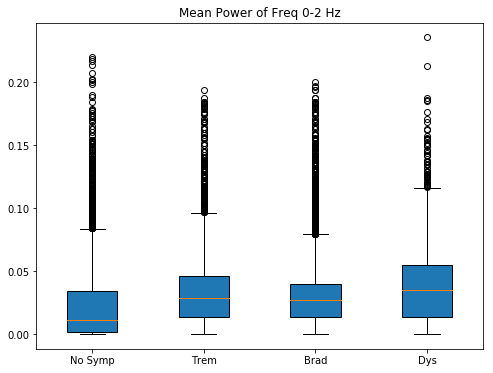

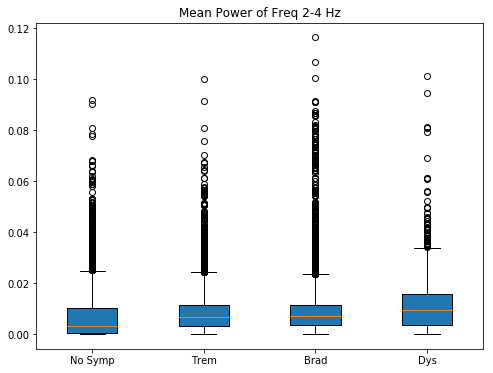

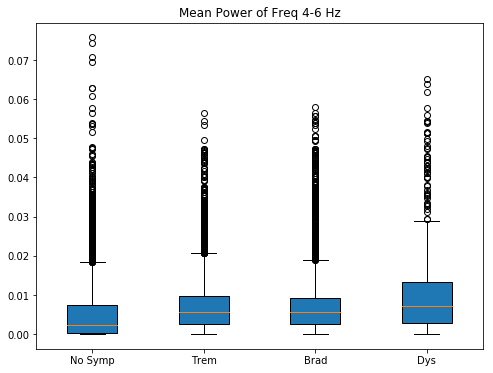

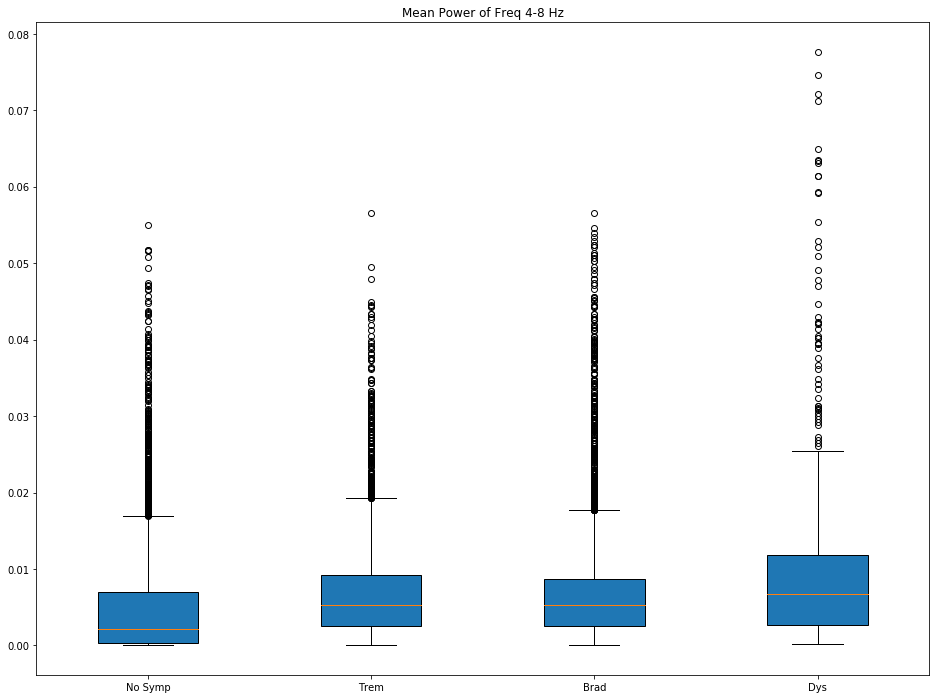

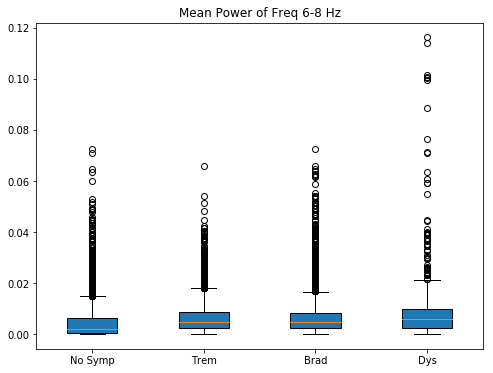

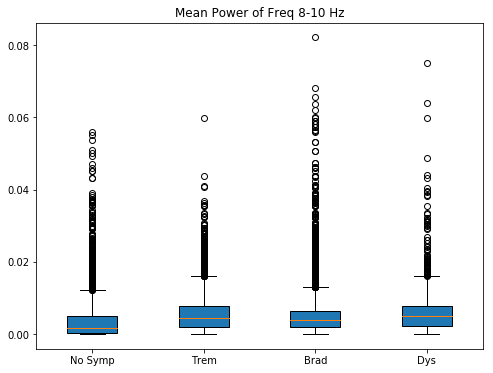

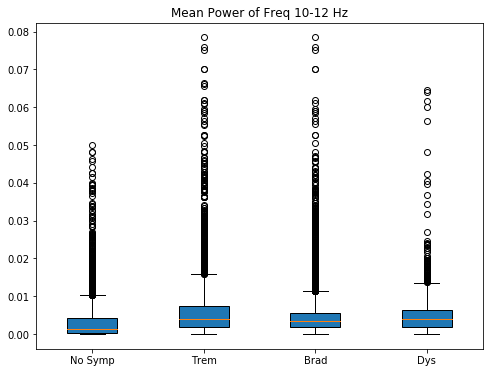

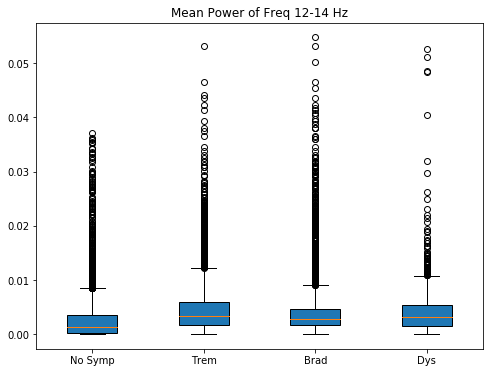

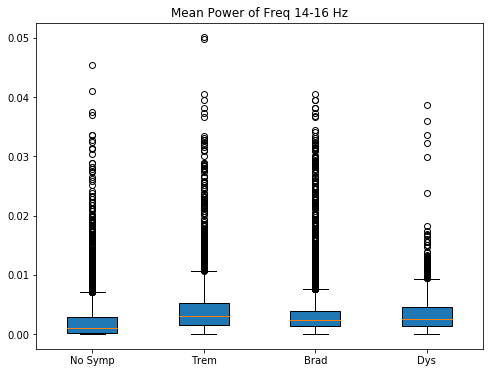

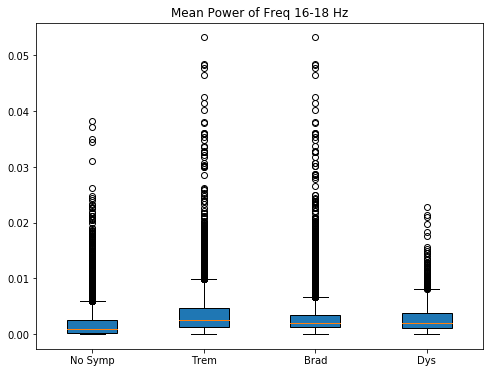

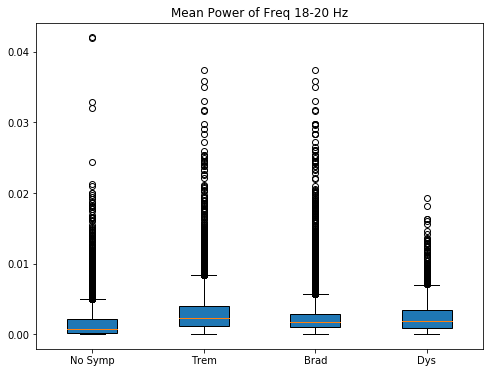

In [183]:
# NoSympFreqData = ClinicFreqData[((ClinicFreqData.Tremor == float(0)) | (np.isnan(ClinicFreqData.Tremor))) &
#                                 ((ClinicFreqData.Bradykinesia == float(0)) | (np.isnan(ClinicFreqData.Bradykinesia))) &
#                                 ((ClinicFreqData.Dyskinesia == float(0)) | (np.isnan(ClinicFreqData.Dyskinesia)))]
# TremFreqData = ClinicFreqData[ClinicFreqData.Tremor > 0]
# BradFreqData = ClinicFreqData[ClinicFreqData.Bradykinesia > 0]
# DysFreqData = ClinicFreqData[ClinicFreqData.Dyskinesia > 0]

# for freq in ClinicFreqData.columns[8:]:
#     rangeData = [NoSympFreqData[freq], TremFreqData[freq], BradFreqData[freq], DysFreqData[freq]]
#     if freq == '4-8':
#         plt.figure(figsize = (16, 12))
#         plt.boxplot(rangeData, patch_artist = True, labels = ['No Symp', 'Trem', 'Brad', 'Dys'])
#         plt.title('Mean Power of Freq ' + freq + ' Hz')
#         plt.show()
#         continue
#     plt.figure(figsize = (8, 6))
#     plt.boxplot(rangeData, patch_artist = True, labels = ['No Symp', 'Trem', 'Brad', 'Dys'])
#     plt.title('Mean Power of Freq ' + freq + ' Hz')
#     plt.show()

Mean Power of Freq 4-6 Hz
Ttest_indResult(statistic=-21.74332032540757, pvalue=2.5812737872403814e-103)


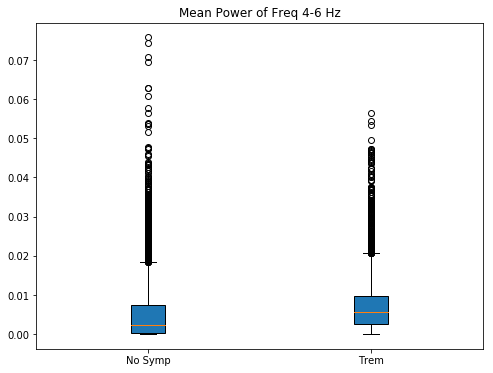

-------------------------------------------------------------------------------
Mean Power of Freq 6-8 Hz
Ttest_indResult(statistic=-22.866567368520208, pvalue=6.943761954595814e-114)


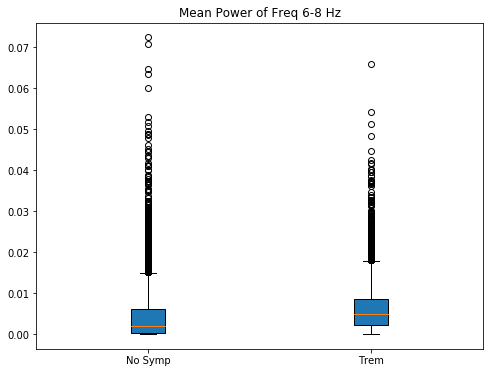

-------------------------------------------------------------------------------


In [136]:
# print('Mean Power of Freq 4-6 Hz')
# print(scipy.stats.ttest_ind(NoSympFreqData['4-6'], TremFreqData['4-6']))
# plt.figure(figsize = (8, 6))
# plt.boxplot([NoSympFreqData['4-6'], TremFreqData['4-6']], patch_artist = True, labels = ['No Symp', 'Trem'])
# plt.title('Mean Power of Freq ' + '4-6' + ' Hz')
# plt.show()
# print('-------------------------------------------------------------------------------')
# print('Mean Power of Freq 6-8 Hz')
# print(scipy.stats.ttest_ind(NoSympFreqData['6-8'], TremFreqData['6-8']))
# plt.figure(figsize = (8, 6))
# plt.boxplot([NoSympFreqData['6-8'], TremFreqData['6-8']], patch_artist = True, labels = ['No Symp', 'Trem'])
# plt.title('Mean Power of Freq ' + '6-8' + ' Hz')
# plt.show()
# print('-------------------------------------------------------------------------------')

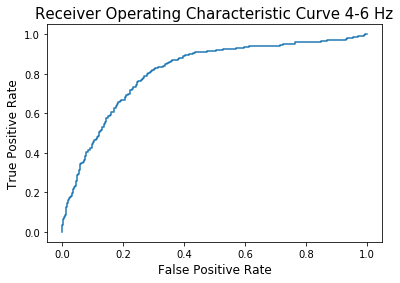

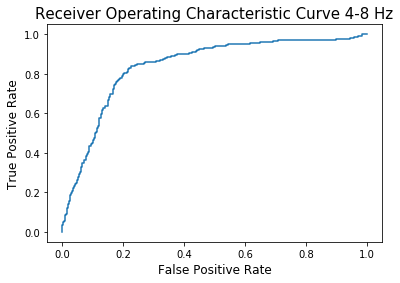

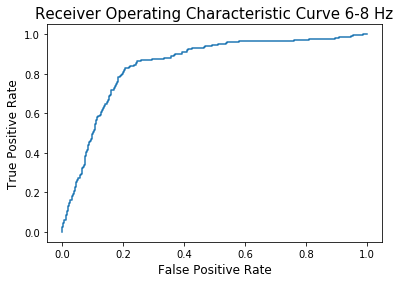

In [184]:
NoTremFreqData = ClinicFreqData[(ClinicFreqData.Tremor == float(0)) & (ClinicFreqData.TaskAbb == 'Stndg')]
TremFreqData = ClinicFreqData[(ClinicFreqData.Tremor > 0) & (ClinicFreqData.TaskAbb == 'Stndg')]

TremNoTremFreq = pd.concat([NoTremFreqData, TremFreqData], ignore_index = True)
TremNoTremFreq.Tremor = TremNoTremFreq.Tremor.apply(lambda x: 1 if x > 0 else x)

TremNoTremFreq = TremNoTremFreq[['Tremor', '4-6', '4-8', '6-8']]

fpr, tpr, thresholds = sklearn.metrics.roc_curve(TremNoTremFreq.Tremor.values, TremNoTremFreq['4-6'].values)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.title('Receiver Operating Characteristic Curve 4-6 Hz', fontsize = 15)
plt.show()

fpr, tpr, thresholds = sklearn.metrics.roc_curve(TremNoTremFreq.Tremor.values, TremNoTremFreq['4-8'].values)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.title('Receiver Operating Characteristic Curve 4-8 Hz', fontsize = 15)
plt.show()

fpr, tpr, thresholds = sklearn.metrics.roc_curve(TremNoTremFreq.Tremor.values, TremNoTremFreq['6-8'].values)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.title('Receiver Operating Characteristic Curve 6-8 Hz', fontsize = 15)
plt.show()


In [204]:
NoTremFreqData = ClinicFreqData[(ClinicFreqData.Tremor == float(0)) & (ClinicFreqData.TaskAbb == 'Stndg')]
TremFreqData = ClinicFreqData[(ClinicFreqData.Tremor > 0) & (ClinicFreqData.TaskAbb == 'Stndg')]

StndgTremFreq = pd.concat([NoTremFreqData, TremFreqData], ignore_index = True)
StndgTremFreq.Tremor = StndgTremFreq.Tremor.apply(lambda x: 1 if x > 0 else x)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(StndgTremFreq.Tremor.values, StndgTremFreq['4-8'].values)

StndgTremROC = pd.DataFrame()
StndgTremROC['fpr'] = fpr
StndgTremROC['tpr'] = tpr
StndgTremROC['thresholds'] = thresholds
StndgTremROC['dist01'] = np.sqrt((1-StndgTremROC.tpr)**2 + StndgTremROC.fpr**2)

StndgTremThreshold = StndgTremROC.thresholds[StndgTremROC.dist01 == min(StndgTremROC.dist01)].values

StndgTremFreq = StndgTremFreq[['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall', '4-8']]


NoTremFreqData = ClinicFreqData[(ClinicFreqData.Tremor == float(0)) & (ClinicFreqData.TaskAbb == 'Sitng')]
TremFreqData = ClinicFreqData[(ClinicFreqData.Tremor > 0) & (ClinicFreqData.TaskAbb == 'Sitng')]

SitngTremFreq = pd.concat([NoTremFreqData, TremFreqData], ignore_index = True)
SitngTremFreq.Tremor = SitngTremFreq.Tremor.apply(lambda x: 1 if x > 0 else x)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(SitngTremFreq.Tremor.values, SitngTremFreq['4-8'].values)

SitngTremROC = pd.DataFrame()
SitngTremROC['fpr'] = fpr
SitngTremROC['tpr'] = tpr
SitngTremROC['thresholds'] = thresholds
SitngTremROC['dist01'] = np.sqrt((1-SitngTremROC.tpr)**2 + SitngTremROC.fpr**2)

SitngTremThreshold = SitngTremROC.thresholds[SitngTremROC.dist01 == min(SitngTremROC.dist01)].values

SitngTremFreq = SitngTremFreq[['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall', '4-8']]

In [236]:
StndgTremThreshold, SitngTremThreshold

(array([0.00071482]), array([0.00039475]))

In [291]:
StndgTremFreq['TremorFreq'] = StndgTremFreq['4-8'].apply(lambda x: 1 if x > float(StndgTremThreshold) else 0)
StndgTremFreq[StndgTremFreq.Tremor != StndgTremFreq.TremorFreq].groupby(['SubjID', 'Visit', 'TaskAbb']).size()

SubjID  Visit  TaskAbb
1003    0      Stndg       6
        1      Stndg       4
        2      Stndg      10
        4      Stndg       8
        5      Stndg       8
1004    0      Stndg       5
        3      Stndg       9
        4      Stndg       4
        6      Stndg       7
1005    2      Stndg       2
1007    0      Stndg       3
        1      Stndg       2
        2      Stndg       1
1009    1      Stndg       6
        5      Stndg       1
        6      Stndg      11
1016    2      Stndg       7
        3      Stndg       3
        4      Stndg       2
        5      Stndg       4
        6      Stndg       4
1018    5      Stndg       2
1019    0      Stndg       1
1020    6      Stndg       9
1023    1      Stndg       2
        4      Stndg       1
        6      Stndg       1
1024    0      Stndg       2
        1      Stndg       5
        3      Stndg       9
                          ..
1029    6      Stndg       2
1032    1      Stndg       1
1038    0      Stndg

In [292]:
SitngTremFreq['TremorFreq'] = SitngTremFreq['4-8'].apply(lambda x: 1 if x > float(SitngTremThreshold) else 0)
SitngTremFreq[SitngTremFreq.Tremor != SitngTremFreq.TremorFreq].groupby(['SubjID', 'Visit', 'TaskAbb']).size()

SubjID  Visit  TaskAbb
1003    0      Sitng       5
        1      Sitng      16
        2      Sitng      12
        3      Sitng       6
        4      Sitng       3
        5      Sitng       5
1004    2      Sitng       8
        3      Sitng       2
        4      Sitng       4
        6      Sitng       1
1005    2      Sitng       3
        3      Sitng      10
1007    0      Sitng       4
        3      Sitng       2
1009    3      Sitng       2
        4      Sitng       1
1016    1      Sitng       4
        2      Sitng       1
        3      Sitng       6
        4      Sitng      13
        5      Sitng      11
1018    2      Sitng       1
1019    0      Sitng       6
        1      Sitng       1
        2      Sitng       2
        3      Sitng       2
        4      Sitng       2
        5      Sitng       3
        6      Sitng       8
1023    1      Sitng       1
                          ..
1039    5      Sitng       1
1043    0      Sitng       4
        1      Sitng

In [274]:
clinicData = pd.read_csv(os.path.join(clinicpath, 'Metadata Tables', 'Table4.csv'))

clinicStndg = clinicData[(clinicData.TaskAbb == 'Stndg')]

StndgClinicData = pd.DataFrame()
TaskData = pd.DataFrame()
for task in clinicStndg.iterrows():
    file = str(int(task[1]['SubjID'])) + '_' + str(VisitNumber[task[1]['Visit']]) + '_' + task[1]['TaskAbb']
    TaskData['SubjID'] = [int(task[1]['SubjID'])]
    TaskData['Visit'] = [VisitNumber[task[1]['Visit']]]
    TaskData['TaskAbb'] = [task[1]['TaskAbb']]
    if not type(task[1]['Side']) == str:
        continue
    TaskData['Tremor'] = [task[1]['Tremor - ' + task[1]['Side']]]
    
    if StndgClinicData.empty:
        StndgClinicData = TaskData
        continue
    StndgClinicData = pd.concat([StndgClinicData, TaskData], ignore_index = True)

clinicSitng = clinicData[(clinicData.TaskAbb == 'Sitng')]

SitngClinicData = pd.DataFrame()
TaskData = pd.DataFrame()
for task in clinicSitng.iterrows():
    file = str(int(task[1]['SubjID'])) + '_' + str(VisitNumber[task[1]['Visit']]) + '_' + task[1]['TaskAbb']
    TaskData['SubjID'] = [int(task[1]['SubjID'])]
    TaskData['Visit'] = [VisitNumber[task[1]['Visit']]]
    TaskData['TaskAbb'] = [task[1]['TaskAbb']]
    if not type(task[1]['Side']) == str:
        continue
    TaskData['Tremor'] = [task[1]['Tremor - ' + task[1]['Side']]]
    
    if SitngClinicData.empty:
        SitngClinicData = TaskData
        continue
    SitngClinicData = pd.concat([SitngClinicData, TaskData], ignore_index = True)

In [283]:
StndgClinicData.head()

,SubjID,Visit,TaskAbb,Tremor
0,1003,1,Stndg,0.0
1,1003,1,Stndg,0.0
2,1003,2,Stndg,0.0
3,1003,3,Stndg,0.0
4,1003,4,Stndg,1.0


In [284]:
SitngClinicData.head()

,SubjID,Visit,TaskAbb,Tremor
0,1003,1,Sitng,0.0
1,1003,1,Sitng,0.0
2,1003,2,Sitng,0.0
3,1003,3,Sitng,0.0
4,1003,4,Sitng,1.0


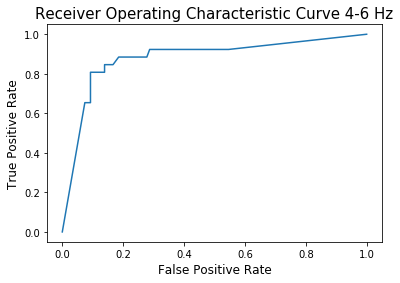

In [289]:
StndgFreqPred = pd.DataFrame()
StndgScorePred = pd.DataFrame()
for score in StndgClinicData.iterrows():
    totClips = len(StndgTremFreq[(StndgTremFreq.SubjID == score[1]['SubjID']) & 
                                 (StndgTremFreq.Visit == score[1]['Visit'])])
    if totClips == 0:
        continue
    TremFreqClips = len(StndgTremFreq[(StndgTremFreq.SubjID == score[1]['SubjID']) & 
                                      (StndgTremFreq.Visit == score[1]['Visit']) & 
                                      (StndgTremFreq.TremorFreq == 1)])
    
    StndgScorePred['SubjID'] = [score[1]['SubjID']]
    StndgScorePred['Visit'] = [score[1]['Visit']]
    StndgScorePred['TaskAbb'] = [score[1]['TaskAbb']]
    StndgScorePred['Tremor'] = [int(score[1]['Tremor'])]
    StndgScorePred['TremFreq'] = [TremFreqClips / totClips]
    
    if StndgFreqPred.empty:
        StndgFreqPred = StndgScorePred
        continue
    StndgFreqPred = pd.concat([StndgFreqPred, StndgScorePred], ignore_index = True)

StndgFreqPred['TremorBool'] = StndgFreqPred.Tremor.apply(lambda x: 1 if x > 0 else x)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(StndgFreqPred.TremorBool.values, StndgFreqPred.TremFreq.values)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.title('Receiver Operating Characteristic Curve 4-6 Hz', fontsize = 15)
plt.show()

In [294]:
StndgFreqPred[StndgFreqPred.Tremor > 0]

,SubjID,Visit,TaskAbb,Tremor,TremFreq,TremorBool
4,1003,4,Stndg,1,0.000000,1
19,1009,1,Stndg,2,0.500000,1
21,1009,3,Stndg,2,1.000000,1
24,1009,6,Stndg,1,0.000000,1
61,1029,1,Stndg,1,0.307692,1
103,1046,1,Stndg,1,1.000000,1
104,1046,2,Stndg,1,1.000000,1
105,1046,3,Stndg,1,1.000000,1
106,1046,4,Stndg,2,1.000000,1
107,1046,5,Stndg,2,1.000000,1


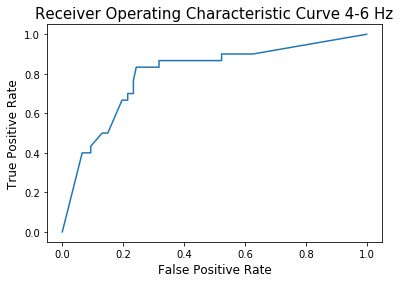

In [290]:
SitngFreqPred = pd.DataFrame()
SitngScorePred = pd.DataFrame()
for score in SitngClinicData.iterrows():
    totClips = len(SitngTremFreq[(SitngTremFreq.SubjID == score[1]['SubjID']) & 
                                 (SitngTremFreq.Visit == score[1]['Visit'])])
    if totClips == 0:
        continue
    TremFreqClips = len(SitngTremFreq[(SitngTremFreq.SubjID == score[1]['SubjID']) & 
                                      (SitngTremFreq.Visit == score[1]['Visit']) & 
                                      (SitngTremFreq.TremorFreq == 1)])
    
    SitngScorePred['SubjID'] = [score[1]['SubjID']]
    SitngScorePred['Visit'] = [score[1]['Visit']]
    SitngScorePred['TaskAbb'] = [score[1]['TaskAbb']]
    SitngScorePred['Tremor'] = [int(score[1]['Tremor'])]
    SitngScorePred['TremFreq'] = [TremFreqClips / totClips]
    
    if SitngFreqPred.empty:
        SitngFreqPred = SitngScorePred
        continue
    SitngFreqPred = pd.concat([SitngFreqPred, SitngScorePred], ignore_index = True)

SitngFreqPred['TremorBool'] = SitngFreqPred.Tremor.apply(lambda x: 1 if x > 0 else x)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(SitngFreqPred.TremorBool.values, SitngFreqPred.TremFreq.values)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.title('Receiver Operating Characteristic Curve 4-6 Hz', fontsize = 15)
plt.show()